In [50]:
import ijson
import itertools
import random
import numpy as np
import sys, os
import pandas as pd 
import torch
from torchsummary import summary
from torchtext import data
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, TensorDataset,DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
from docopt import docopt
import time
from torch.autograd import Variable
import transformers
# from apex import amp
import shutil
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline


SEED = 7219
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import transformers specific packages
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import  BertForSequenceClassification, BertForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup
#from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup
#

In [3]:
# Set the device and empty cache 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# cudnn.benchmark = True
torch.cuda.empty_cache()
device
#model.to(device)

device(type='cpu')

In [22]:
def tokenize_text(df, max_seq_len):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq_len] for text in df.text.values
    ]


def pad_text(tokenized_text, max_seq_len):
    return np.array([el + [0] * (max_seq_len - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq_len):
    tokenized_text = tokenize_text(df, max_seq_len)
    padded_text = pad_text(tokenized_text, max_seq_len)
    return torch.tensor(padded_text)


def targets_to_tensor(df):
    return torch.tensor(df.label.values, dtype=torch.float32)

In [42]:
class BertCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(BertCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(embed_num, embed_dim)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, kernel_num, (Ks, embed_dim)) for Ks in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
        self.sigmoid = nn.Sigmoid()
        

    
    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output


In [46]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

# Define constants and paths #

In [4]:
seed = 7843
bert_model_name = "bert-base-uncased"
# Convert TF checkpoint to pytorch chckpoint and then use as input to class object
bert_model_path = "/Users/debalinamaiti/Documents/GraduateStudy/MIDS/W251/FinalProject/mids-w251-final-project/models/Tranformer_based/uncased_L-12_H-768_A-12/"
# data_path = "/Users/suhasgupta/w251/mids-w251-final-project/data/nlp.cs.princeton.edu/SARC/2.0/pol/"
data_path = "/Users/debalinamaiti/Documents/GraduateStudy/MIDS/W251/FinalProject/mids-w251-final-project/models/Tranformer_based/data/"
work_dir = "/Users/debalinamaiti/Documents/GraduateStudy/MIDS/W251/FinalProject/mids-w251-final-project/models/Tranformer_based/workingdir/"

#tokenizer = BertTokenizer.from_pretrained(bert_model_name, cache_dir=None,do_lower_case=True)
max_seq_len = 64


# Data Loading

In [19]:

# Load and check the dataset from files on disk 
train_file_name = data_path+'small_train.csv'
test_file_name  = data_path+'small_test.csv'
# train_file_name = data_path+'train_balanced_with_label.csv'
# test_file_name = data_path+'test_balanced_with_label.csv'

all_train_df = pd.read_csv(train_file_name)
test_df = pd.read_csv(test_file_name)

# Fill NA with DUMMY VALUE
# all_train_df.text = all_train_df.text.fillna("DUMMY_VALUE")
# test_df.text = test_df.text.fillna("DUMMY_VALUE")

# Create a train, valid split
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_train_df, test_size=0.2,random_state=seed)

# Fill NA with DUMMY VALUE
train_data   = train_df.text.fillna("DUMMY_VALUE")
train_labels = train_df.label
valid_data  = valid_df.text.fillna("DUMMY_VALUE")
valid_labels = valid_df.label
test_data  = test_df.text.fillna("DUMMY_VALUE")
test_labels = test_df.label

train_size,valid_size,test_size = len(train_df),len(valid_df),len(test_df)
print(train_size,valid_size,test_size)
print(train_df)

799 200 999
     Unnamed: 0                                               text  label
343         343  gasp, the injustice of not being able to be a ...      1
434         434  if reddit was run by racism-powered generators...      0
778         778  Do they honestly think anyone is going to want...      0
17           17  Am I weird if almost every one of those pictur...      0
511         511      It's worth every penny to bring Jeeezus back.      1
..          ...                                                ...    ...
299         299  If someone x-ray'd my brand new computer they'...      0
168         168                    Another marijuana related death      1
613         613  Thin privilege is not needing a billboard to f...      0
166         166     Let's bring Carlos Lee back while we're at it.      1
629         629  Yeah... that'll send them away without suspicion.      1

[799 rows x 3 columns]


# Create Dataset

In [8]:
# train_dataset = CreateDataset(train_data_tokenized,train_labels)
# valid_dataset = CreateDataset(valid_data_tokenized,valid_labels)
# test_dateset = CreateDataset(valid_data_tokenized,valid_labels) # Added by D

# Loading pre-trained BERT Model

In [9]:
## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, bert_model_name)

tokenizer = tokenizer_class.from_pretrained(pretrained_weights, cache_dir=None,do_lower_case=True)

# Load pretrained model

basemodel = model_class.from_pretrained(pretrained_weights)
# Create a model object 
# bert_model=Bert_Model(train_df=train_df,
#                       test_df=test_df,
#                       bert_model_name=bert_model_name,
#                       bert_model_path=bert_model_path,
#                       tokenizer=tokenizer,
#                       max_seq_length=max_seq_len)

## Tokenization ##

In [14]:
train_indices = tokenize_and_pad_text(train_df, max_seq_len)
val_indices = tokenize_and_pad_text(valid_df, max_seq_len)
test_indices = tokenize_and_pad_text(test_df, max_seq_len)

In [13]:
train_indices.shape

torch.Size([799, 64])

# Run BERT Model

In [16]:
with torch.no_grad():
    x_train = basemodel(train_indices)[0]  # Models outputs are tuples
    x_val = basemodel(val_indices)[0]
    x_test = basemodel(test_indices)[0]

In [23]:
y_train = targets_to_tensor(train_df)
y_val = targets_to_tensor(valid_df)
y_test = targets_to_tensor(test_df)

In [33]:
x_train[0].shape
x_train.shape[1]
x_train.shape[2]

torch.Size([64, 768])

64

768

In [36]:
len(y_train)
y_train[0]

799

tensor(1.)

# Build Custom BERT CNN Model

## Initialize Model Parameters ##

In [38]:
#n_batch = 1#int(len(train_data_tokenized)/params['batch_size'])
total_loss = 0


embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = 1
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [43]:
BertCnnModel = BertCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static
    )

#BertCnnModel.train()

## Define Training Parameters##

In [45]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(BertCnnModel.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [49]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    BertCnnModel.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = BertCnnModel(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    BertCnnModel.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
            y_pred = BertCnnModel(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 1 Train loss: 0.69. Validation loss: 0.66. Elapsed time: 3.48s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 2 Train loss: 0.67. Validation loss: 0.63. Elapsed time: 3.36s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 3 Train loss: 0.65. Validation loss: 0.61. Elapsed time: 3.22s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 4 Train loss: 0.63. Validation loss: 0.57. Elapsed time: 3.20s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 5 Train loss: 0.60. Validation loss: 0.52. Elapsed time: 3.22s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 6 Train loss: 0.58. Validation loss: 0.52. Elapsed time: 3.32s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 7 Train loss: 0.55. Validation loss: 0.47. Elapsed time: 2.90s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 8 Train loss: 0.52. Validation loss: 0.44. Elapsed time: 2.94s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 9 Train loss: 0.49. Validation loss: 0.38. Elapsed time: 3.34s.


BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

BertCNN(
  (embed): Embedding(64, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 10 Train loss: 0.47. Validation loss: 0.34. Elapsed time: 3.54s.


Text(0.5, 1.0, 'Losses')

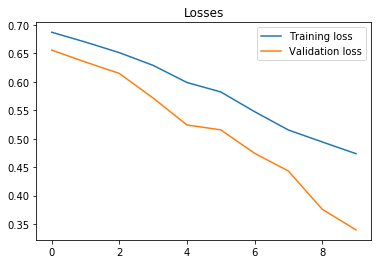

In [51]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")